# Indicator Analysis

This Notebook implements the analysis and visualization of indicator data. All processing and analysis operations can be accessed and modified in indicator_util.py.

Below is a simple example of the trend statistics of an indicator in an experiment. First you need to set up the list of all experiment names ``exp_list_all``, which should be the list consisting of the ``trace_path`` you entered in preprocessing. ``exp_list_x`` refers to the list of experiment names that each app group x contains.

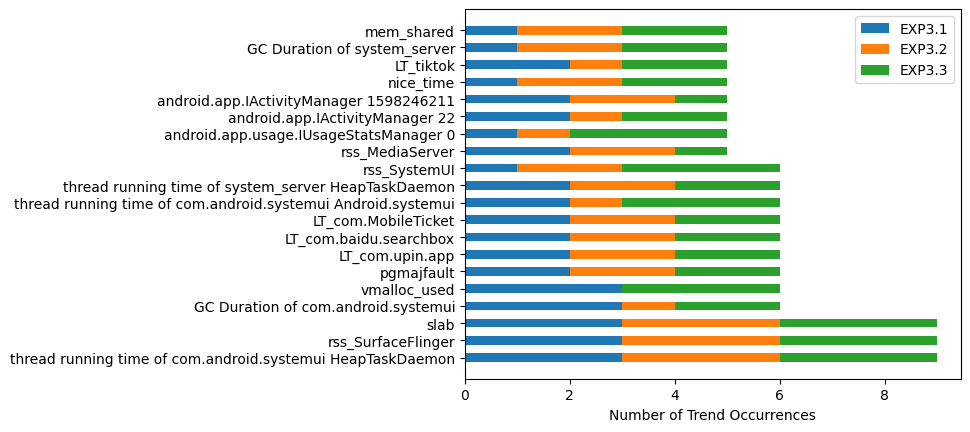

In [1]:
%load_ext autoreload
%autoreload 2
import indicator_util 
import pandas as pd
import pickle
# Specify the experiment name corresponding to each group of app experiments
exp_list_all = ['2-21-10app1', '2-27-10app1', '3-1-10app1-modified','4-5-10app2','4-6-10app2', '3-8-10app2', '3-13-10app3','3-19-10app3','3-20-10app3']
exp_list_1 = ['2-21-10app1', '2-27-10app1', '3-1-10app1-modified']
exp_list_2 = ['4-5-10app2', '4-6-10app2', '3-8-10app2']
exp_list_3 = ['3-13-10app3','3-19-10app3','3-20-10app3']

# Reading of preprocessed indicator data and trend analysis
indicators_data = pickle.load(open('D:\Lab\Android\data\indicators_data.pkl', 'rb'))
indicators_intrested = pd.read_csv('D:\Lab\Android\data\indicators_intrested.csv', index_col=0)

indicator_util.trend_occur(exp_list_1, exp_list_2, exp_list_3, indicators_intrested)

Based on the instructions in the figure, you should initially filter out the metrics that show a trend in more than half of the experiments and populate the following ``sys_indicator`` and ``user_indicator``, which represent system-plane and user-plane metrics, respectively.

Below we perform a correlation analysis of the system- and user-facing indicators.

In [ ]:
sys_indicators = [
                    'slab',
                    'com.android.systemui HeapTaskDaemon',
                    'rss_sf',
                    'com.android.systemui',
                    'vmalloc_used',
                    'pgmajfault',
                    'com.android.systemui ndroid.systemui',
                    'system_server HeapTaskDaemon',
                    'rss_ui',
                    'rss_ms',
                    'surfaceflinger surfaceflinger',
                    'system_server android.anim',
                    'nice_time',
                    'android.app.usage.IUsageStatsManager 0',
                    'android.app.IActivityManager 22',
                    'android.app.IActivityManager 1598246211',
                    'mem_shared',
                    'system_server',
                ]
user_indicators = [
                    'LT_7',
                    'LT_10',
                    'LT_11',
                    'LT_16',
                    'jank',
                    'LT_40'
                ]

indicator_util.corr_analysis(indicators_data, sys_indicators, user_indicators)

Through correlation analysis, we were able to select a number of metrics that are closely related to the user interface, manually filtered and populated with ``indicators_selected`` , and combined the above results to assess the confidence of the metrics, populated with ``indicators_confidence``.

Next, determine the aging threshold for the indicator. Specify the target metric and its threshold (in this case, we specify 'jank' jerky frames to 10 as the threshold), then ``threshold_each_exp()`` will get the corresponding thresholds of other metrics, and filter out the metrics that are too scattered in ``threshold_filt()``, to get the final metrics and their thresholds.

In [3]:
indicators_selected = ['LT_7', 'LT_10', 'LT_11', 'LT_40', 'jank', 'pgmajfault', 
                       'slab','rss_sf','com.android.systemui HeapTaskDaemon','system_server',
                       'vmalloc_used', 'rss_ui', 'com.android.systemui ndroid.systemui', 'system_server HeapTaskDaemon', 'com.android.systemui','android.app.IActivityManager 22',
                       'rss_ms', 'mem_shared', 'nice_time'
                    ]
indicators_confidence = {'LT_7': 'high', 'LT_10': 'high', 'LT_11': 'high', 'LT_40': 'high', 'jank': 'high', 'pgmajfault': 'high', 
                       'slab': 'high','rss_sf': 'high','com.android.systemui HeapTaskDaemon': 'high','system_server': 'high',
                       'vmalloc_used': 'mid', 'rss_ui': 'mid', 'com.android.systemui ndroid.systemui': 'mid', 'system_server HeapTaskDaemon': 'mid', 'com.android.systemui': 'mid','android.app.IActivityManager 22': 'low',
                       'rss_ms': 'low', 'mem_shared': 'low', 'nice_time': 'low'}

threshold_by_exp = indicator_util.threshold_each_exp(exp_list_all, indicators_data, indicators_selected,'jank', 10)
threshold = indicator_util.threshold_filt(indicators_data, indicators_selected, threshold_by_exp)
indicators_selected = list(threshold.keys())
threshold

LT_11                                   0.167008
jank                                    0.200582
LT_40                                   0.258537
com.android.systemui                    0.323794
rss_ms                                  0.362089
android.app.IActivityManager 22         0.444124
LT_7                                    0.453718
vmalloc_used                            0.499083
nice_time                               0.517527
rss_sf                                  0.520285
com.android.systemui HeapTaskDaemon     0.527778
system_server HeapTaskDaemon            0.547164
rss_ui                                  0.600439
system_server                           0.626225
com.android.systemui ndroid.systemui    0.671210
pgmajfault                              0.690763
LT_10                                   0.715935
slab                                    0.787486
mem_shared                              0.887138
Name: quar, dtype: float64


{'LT_11': (309, 599.8888888888889),
 'jank': (3.833791004108394, 9.682428710790582),
 'LT_40': (49.36426234, 78.64406572415928),
 'com.android.systemui': (725.4190000000001, 2905.3685555555553),
 'rss_ms': (1650.6666666666667, 5132.666666666667),
 'android.app.IActivityManager 22': (299.177, 1652.9174444444443),
 'LT_7': (675, 1090.7777777777778),
 'vmalloc_used': (268211.3333333333, 363628.7198653199),
 'nice_time': (135656.33333333302, 409515.9675084175),
 'rss_sf': (28015.333333333332, 37965.96296296296),
 'com.android.systemui HeapTaskDaemon': (26.0, 241.22222222222223),
 'system_server HeapTaskDaemon': (1001.0, 1779.111111111111)}

The ``draw_aging_level()`` function implements the solving and plotting of the aging index based on the above thresholds, and marks the rounds in which the Aging Warning (alarm) and Rebirth Preparation (alert) appeared and the expected rounds in which Aging Failure appeared in each experiment based on the dynamic control strategy.

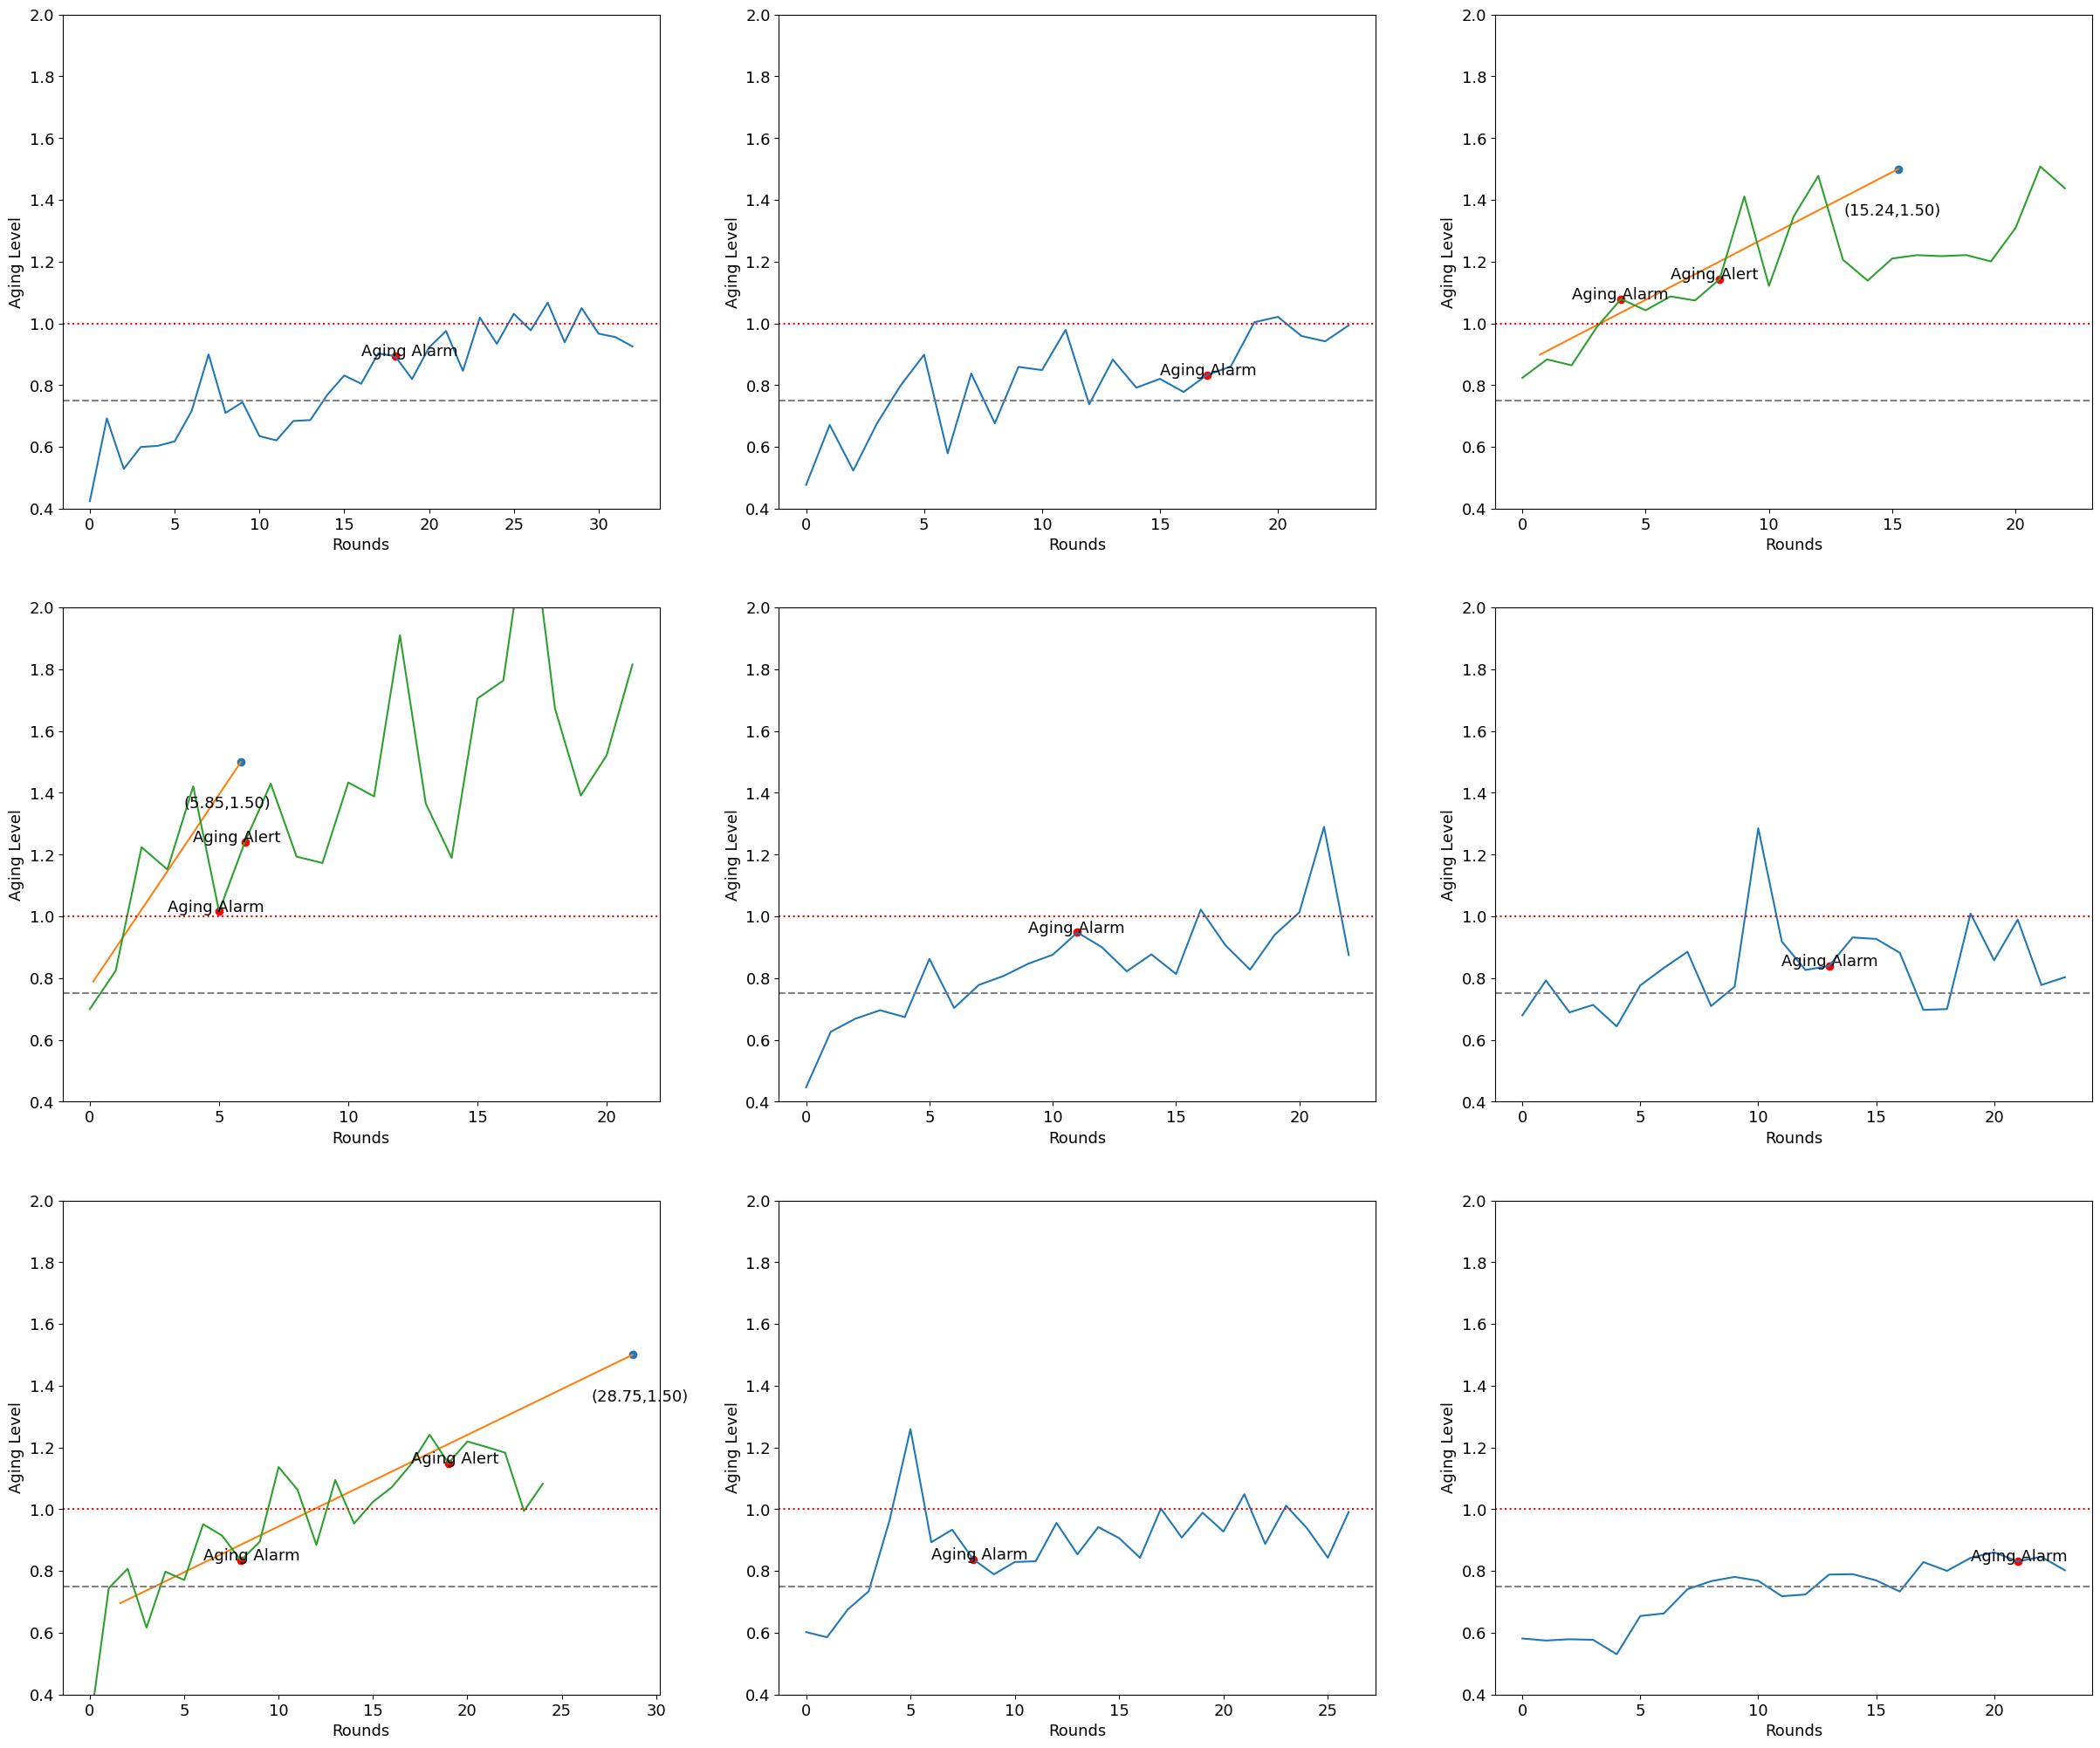

In [7]:
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 13})
plt.figure(figsize=(30, 25))
aging_level_data = indicator_util.draw_aging_level(indicators_data, indicators_selected, indicators_confidence, exp_list_all, threshold,window=5, alarm_threshold=0.75, alert_threshold=1.0, aged_threshold=1.5)